In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10,fashion_mnist

# fashion_mnist veri setini yükle
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Veriyi düzleştir
x_train_flat = x_train.reshape(-1, 28 * 28 )
x_test_flat = x_test.reshape(-1, 28 * 28 )

# StandardScaler ile standartlaştırma
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Eğitim ve doğrulama veri setini ayır
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [3]:
import numpy as np

# Eksik değer kontrolü
def check_missing_values(data, name="Veri"):
    missing = np.isnan(data).sum()  # NaN değerleri kontrol et
    infinite = np.isinf(data).sum()  # Sonsuz değerleri kontrol et
    if missing > 0 or infinite > 0:
        print(f"{name} setinde eksik (NaN) veya sonsuz (Inf) değerler var!")
        print(f"NaN sayısı: {missing}, Sonsuz sayısı: {infinite}")
    else:
        print(f"{name} setinde eksik veya sonsuz değer yok.")

# Eğitim, doğrulama ve test setlerini kontrol et
check_missing_values(x_train_scaled, "Eğitim")
check_missing_values(x_val, "Doğrulama")
check_missing_values(x_test_scaled, "Test")


Eğitim setinde eksik veya sonsuz değer yok.
Doğrulama setinde eksik veya sonsuz değer yok.
Test setinde eksik veya sonsuz değer yok.


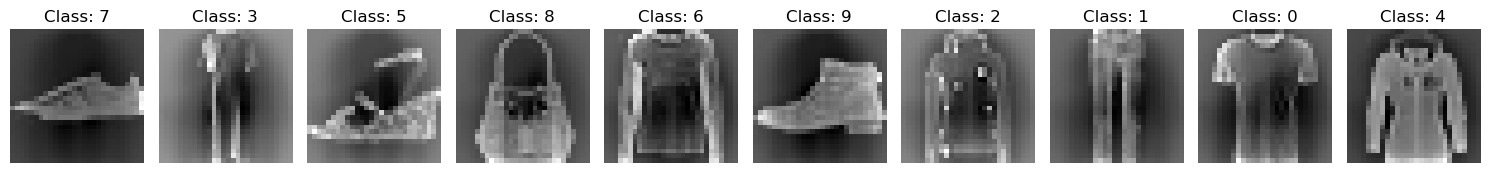

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Her sınıf için bir örnek göster
def show_class_images(data, labels, num_classes=10):
    plt.figure(figsize=(15, 5))
    shown_classes = set()
    count = 0

    for i in range(len(data)):
        label = np.argmax(labels[i])  # Etiketi belirle
        if label not in shown_classes:  # Daha önce gösterilmediyse
            plt.subplot(1, num_classes, count + 1)
            img = data[i].reshape(28, 28)  # Görüntüyü yeniden şekillendir
            plt.imshow((img - img.min()) / (img.max() - img.min()), cmap='gray')  # Normalize et
            plt.title(f"Class: {label}")
            plt.axis("off")
            shown_classes.add(label)
            count += 1

        if count == num_classes:  # Tüm sınıflar için bir örnek bulunduysa
            break

    plt.tight_layout()
    plt.show()

# Veri setinde bulunan her sınıf için bir örnek göster
show_class_images(x_train, y_train, num_classes=10)

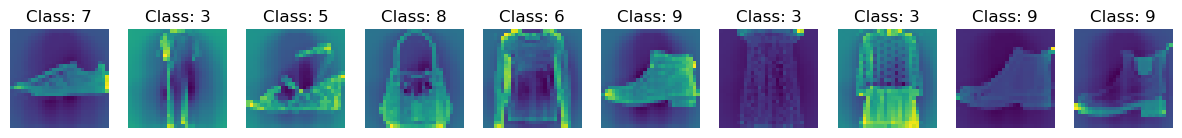

In [4]:
import matplotlib.pyplot as plt

# İlk 10 fotoğrafı göster
def show_sample_images(data, labels, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = data[i].reshape(28, 28)  # Görüntüyü yeniden şekillendir
        plt.imshow((img - img.min()) / (img.max() - img.min()))  # Görüntüyü normalize et
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis("off")
    plt.show()

# İlk 10 eğitim fotoğrafını göster
show_sample_images(x_train, y_train, num_samples=10)

In [5]:
# Veri boyutları kontrolü
print(x_train.shape) # yukarda scaler yaptım
print(y_train.shape)
print(x_test_scaled.shape)
print(y_test.shape)

(48000, 784)
(48000, 10)
(10000, 784)
(10000, 10)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


# MLP modelini tanımlayan fonksiyon
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

def create_mlp_model(layer_sizes, learning_rate, activation, solver, alpha):
    model = Sequential()
    # İlk katman
    model.add(Dense(layer_sizes[0], input_dim=x_train.shape[1], activation=activation, kernel_regularizer='l2'))
    # Ek katmanlar
    for size in layer_sizes[1:]:
        model.add(Dense(size, activation=activation, kernel_regularizer='l2'))
    # Çıkış katmanı
    model.add(Dense(y_train.shape[1], activation='softmax')) # 10 sınıf tahmin edeceğiz diye y_train.shape=10 
    
    # Optimizasyon algoritması
    if solver == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif solver == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    # Model derleme
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid Search parametreleri
mlp_params = {
    'layer_sizes': [[64], [128], [128, 64], [256, 128]],  # Katman ve nöron kombinasyonları
    'learning_rate': [0.001, 0.01],
    'activation': ['relu', 'tanh'],  # Aktivasyon fonksiyonları
    'solver': ['adam', 'sgd'],       # Optimizasyon algoritmaları
    'alpha': [0.0001, 0.001]        # L2 regularization parametresi
}

best_accuracy = 0
best_params = None
best_mlp_model = None

# Tüm kombinasyonları dene
for layer_sizes in mlp_params['layer_sizes']:
    for learning_rate in mlp_params['learning_rate']:
        for activation in mlp_params['activation']:
            for solver in mlp_params['solver']:
                for alpha in mlp_params['alpha']:
                    # Modeli oluştur
                    model = create_mlp_model(layer_sizes, learning_rate, activation, solver, alpha)
                    
                    # Modeli eğit
                    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                        epochs=10, batch_size=64, verbose=0)
                    
                    # Doğrulama setinde tahmin yap
                    y_pred = np.argmax(model.predict(x_val), axis=1)
                    y_true = np.argmax(y_val, axis=1)

                    # Performans metriklerini hesapla
                    precision = precision_score(y_true, y_pred, average='macro')
                    recall = recall_score(y_true, y_pred, average='macro')
                    f1 = f1_score(y_true, y_pred, average='macro')
                    acc = accuracy_score(y_true, y_pred)

                    print(f"Params: {layer_sizes}, LR: {learning_rate}, Act: {activation}, Solver: {solver}, Alpha: {alpha} -> "
                          f"Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                    
                    # En iyi modeli kontrol et ve güncelle
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_params = (layer_sizes, learning_rate, activation, solver, alpha)
                        best_mlp_model = model  # En iyi modeli sakla

print(f"MLP için en iyi parametreler: {best_params} -> Acc: {best_accuracy:.4f}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.0001 -> Acc: 0.8479, Precision: 0.8533, Recall: 0.8481, F1: 0.8496
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: adam, Alpha: 0.001 -> Acc: 0.8591, Precision: 0.8597, Recall: 0.8594, F1: 0.8582
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.0001 -> Acc: 0.8277, Precision: 0.8267, Recall: 0.8283, F1: 0.8267
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [64], LR: 0.001, Act: relu, Solver: sgd, Alpha: 0.001 -> Acc: 0.8277, Precision: 0.8267, Recall: 0.8282, F1: 0.8270
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.0001 -> Acc: 0.8497, Precision: 0.8555, Recall: 0.8502, F1: 0.8505
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: [64], LR: 0.001, Act: tanh, Solver: adam, Alpha: 0.001 -> Acc: 0.8598, Precision: 0.8606, Recall: 0.8602, F1: 0.8587
375

In [36]:
# Test verisi üzerindeki tahminler
y_test_pred = np.argmax(best_mlp_model.predict(x_test_scaled), axis=1)  # Test verisi için tahminler
y_test_true = np.argmax(y_test, axis=1)  # Test verisinin gerçek etiketleri

# Test seti metriklerini hesapla
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average='macro')
test_recall = recall_score(y_test_true, y_test_pred, average='macro')
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

print(f"Test Verisi Sonuçları -> "
      f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Verisi Sonuçları -> Accuracy: 0.8615, Precision: 0.8614, Recall: 0.8615, F1-Score: 0.8610


# Eğitim Süreci Loss ve Accuracy Grafikleri
- Eğitim sürecinde elde ettiğiniz doğruluk ve kayıp metriklerini görselleştirmek için aşağıdaki adımları izleyebilirsiniz

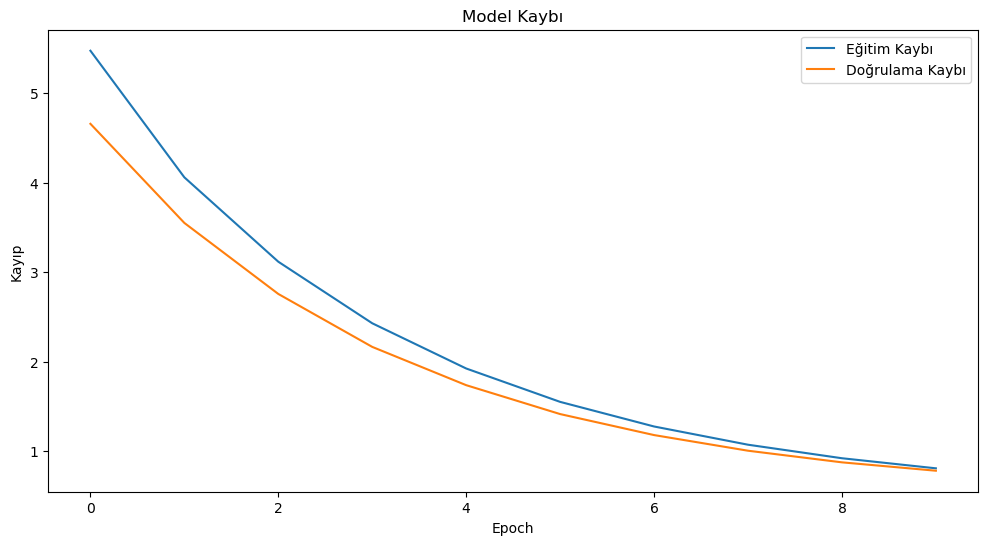

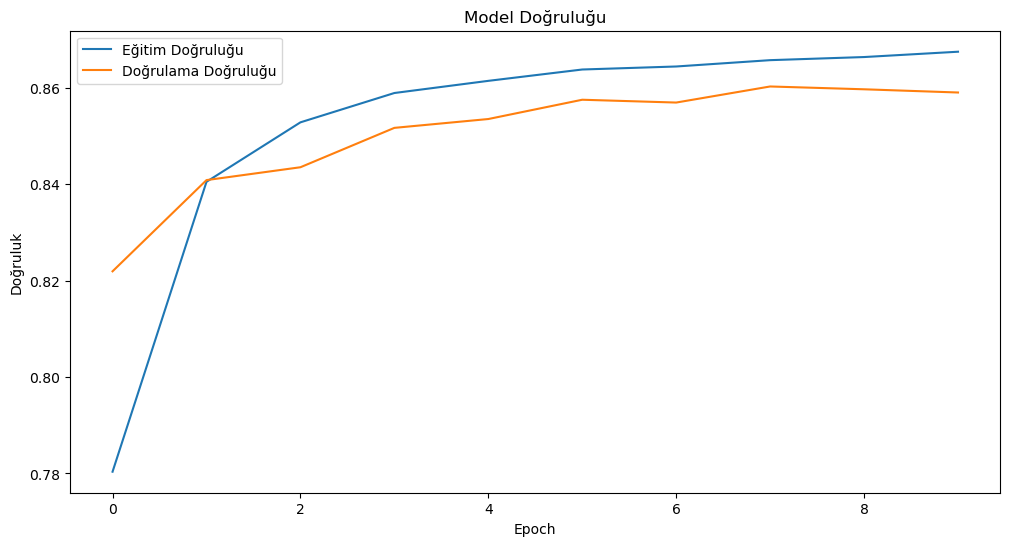

In [28]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını görselleştir
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

# Eğitim ve doğrulama doğruluğunu görselleştir
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.show()

# Modeli eğittikten sonra history nesnesini kullanarak grafikler oluştur
plot_loss(history)
plot_accuracy(history)

# Confusion Matrix ile Sınıf Performansı
- Modelinizin sınıf performansını daha ayrıntılı görmek için bir confusion matrix oluşturabilirsiniz. Bu, modelin hangi sınıflarda hata yaptığını gösterir.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP Modeli - Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.80      0.76      0.78      1000
           3       0.82      0.90      0.85      1000
           4       0.76      0.80      0.78      1000
           5       0.95      0.92      0.94      1000
           6       0.68      0.65      0.66      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.96      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



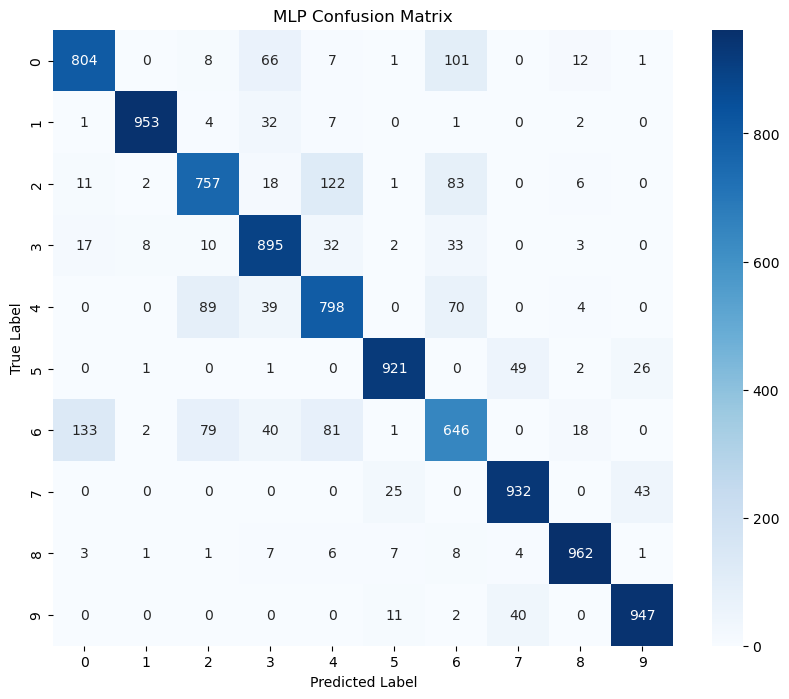

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Confusion Matrix'i çizdirme fonksiyonu
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = range(10)  # CIFAR-10 sınıf sayısı
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# 1. MLP Modeli için en iyi sonucu elde eden modelin tahminlerini alın
# En iyi MLP modelinin tahminlerini al
mlp_y_pred = np.argmax(best_mlp_model.predict(x_test_scaled), axis=1)  # Test verisi üzerinden tahmin yapıyoruz
mlp_y_true = np.argmax(y_test, axis=1)
# 3. Confusion Matrix Görselleştirme
print("MLP Modeli - Sınıflandırma Raporu")
print(classification_report(mlp_y_true, mlp_y_pred))
# Görselleştirme
plot_confusion_matrix(mlp_y_true, mlp_y_pred, title="MLP Confusion Matrix")

# ROC Eğrisi 
- Sınıflar arasında karar sınırlarını incelemek için ROC eğrisini de çizebilirsiniz. Bu, modelinizin True Positive Rate (TPR) ve False Positive Rate (FPR) değerleri arasındaki ilişkiyi gösterir.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


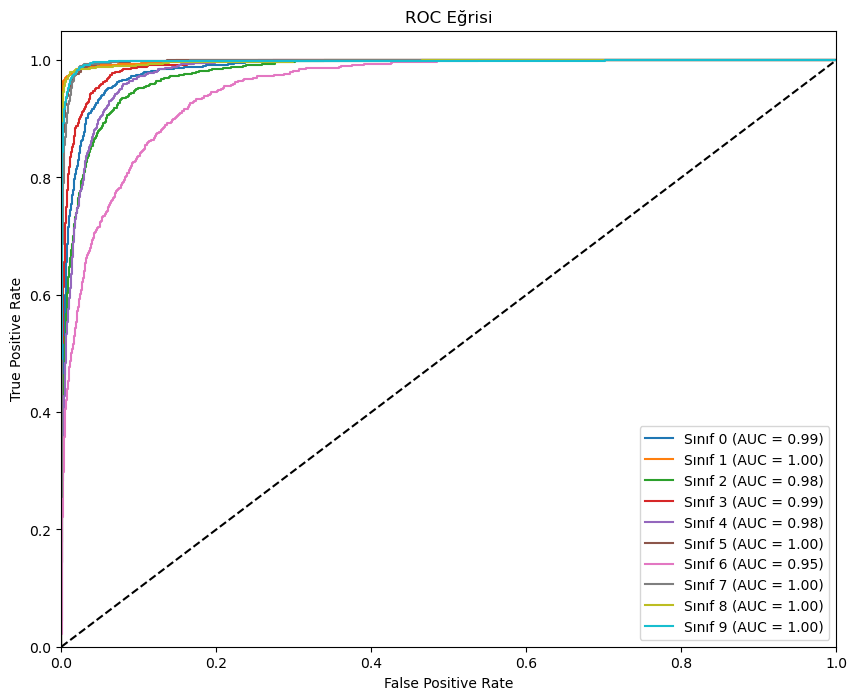

In [29]:
from sklearn.metrics import roc_curve, auc

# Her sınıf için ROC eğrisini çizme
def plot_roc_curve(y_true, y_pred, num_classes=10):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Sınıf {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Eğrisi')
    plt.legend(loc='lower right')
    plt.show()

# Test verisi üzerinde ROC eğrisini çiz
y_pred_prob = best_mlp_model.predict(x_test_scaled)
plot_roc_curve(y_test, y_pred_prob)

# F1 Skoru, Precision ve Recall ile Performans Görselleştirme

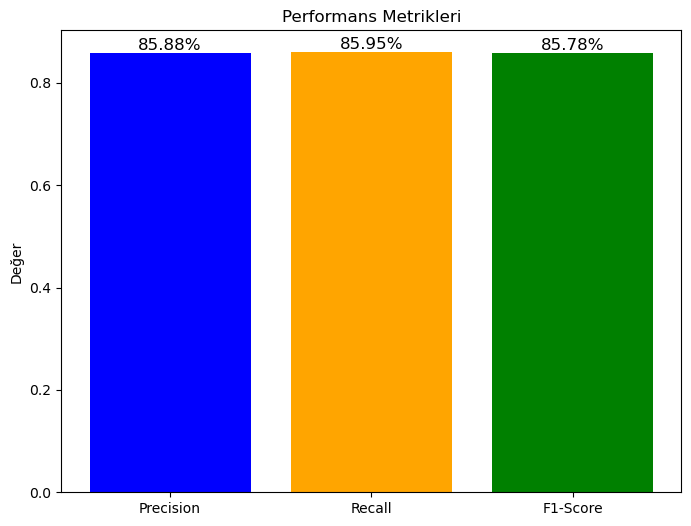

In [31]:
# Metrikleri görselleştir
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

# Yüzdelik değerleri hazırlama
percentages = [f"{value * 100:.2f}%" for value in values]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Performans Metrikleri')
plt.ylabel('Değer')

# Her sütunun üzerine yüzdelik değerini ekle
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             percentage, ha='center', va='bottom', fontsize=12)

plt.show()